In [2]:
import scvelo
import sys
import ot
import scipy as sp
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
import sklearn as sk
from sklearn import manifold 
import pandas as pd

In [2]:
adata = scvelo.datasets.dentategyrus_lamanno(); adata.obs.celltypes = adata.obs.clusters
adata.obs["start_prob"] = pd.read_csv("../../data/dentate_gyrus/start_probs.csv", index_col = 0).start_prob
adata.obs["end_prob"] = pd.read_csv("../../data/dentate_gyrus/end_probs.csv", index_col = 0).end_prob
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.obs["reads"] = np.array(adata.X.sum(-1)).flatten()
adata.obs["logreads"] = np.log(adata.obs["reads"])
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset = True)
sc.pp.scale(adata, max_value=10)
sc.pp.subsample(adata, n_obs = 5000, random_state = 0)

In [3]:
adata.uns['iroot'] = np.argmax(adata.obs.start_prob)

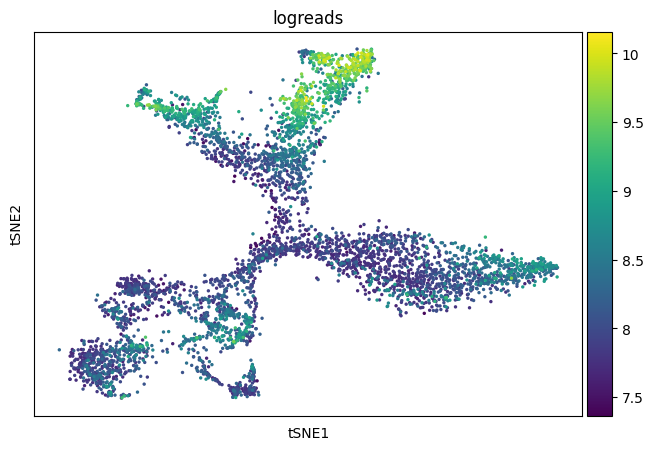

In [4]:
sc.pp.pca(adata, n_comps = 50)
sc.pl.scatter(adata, basis = "tsne", color = "logreads", )

In [5]:
# save as file and run julia script
X = adata.X; np.save("X.npy", X)

In [6]:
# alternatively run scRNA_dentate_jl.ipynb to do a bisection search for entropic OT to match perplexity
# !julia --project=. ../../src/kernel_cmd.jl X.npy 1.0 --mode quad --out_W W_quad.npy --out_u u_quad.npy --diag_inf true
# !julia --project=. ../../src/kernel_cmd.jl X.npy 0.008 --mode ent --out_W W_ent.npy --out_u u_ent.npy --diag_inf true

In [7]:
W = np.load("W_quad.npy") # , np.load("u_quad.npy")
W_ent = np.load("W_ent.npy") # , np.load("u_ent.npy")

In [8]:
np.sort(np.unique(adata.obs.clusters))

array(['CA', 'CA1-Sub', 'CA2-3-4', 'GlialProg', 'Granule', 'ImmAstro',
       'ImmGranule1', 'ImmGranule2', 'Nbl1', 'Nbl2', 'OPC', 'RadialGlia',
       'RadialGlia2', 'nIPC'], dtype=object)

In [9]:
adata.obs.loc[:, "nbrs"] = (W > 0).sum(-1)
# adata.obs.loc[:, "u"] = u

/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:316: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


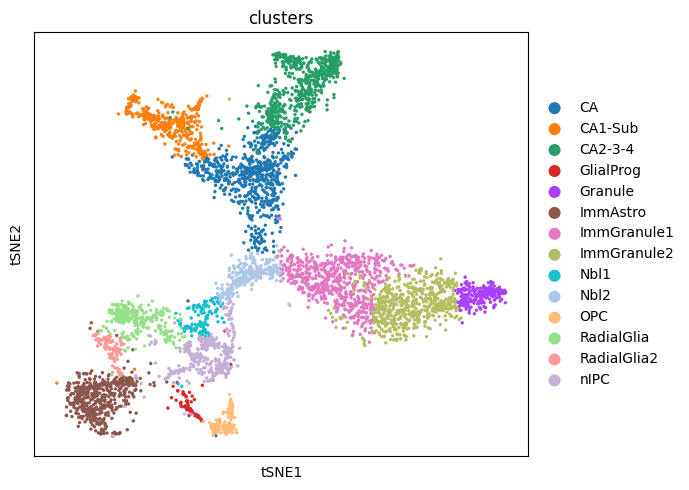

In [10]:
fig, ax = plt.subplots(figsize = (7, 5))
sc.pl.scatter(adata, basis = "tsne", color = "clusters", ax = ax, show = False)
plt.tight_layout()
plt.savefig("../figures/dentategyrus_tsne.pdf", dpi = 300)

In [11]:
import plotly
import plotly.express as px
# Compute spectral embeddings
embed_op = manifold.SpectralEmbedding(n_components = 10, affinity = "precomputed", n_jobs = 16, random_state = 0)
# Quadratic kernel
X_emb_quad = embed_op.fit_transform(W)
# Entropic kernel
X_emb_ent = embed_op.fit_transform(W_ent)
# kNN 
knn_op = sk.neighbors.NearestNeighbors(n_neighbors = 52, algorithm = "auto", n_jobs = 16)
knn_op.fit(X)
A = knn_op.kneighbors_graph(X)
A = (A + A.T)/2
X_emb_knn = embed_op.fit_transform(np.array(A.todense()))

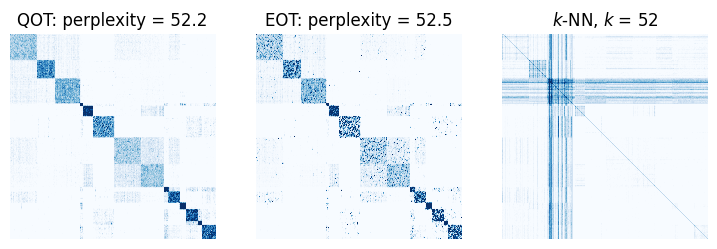

In [67]:
def perplexity(M):
    return np.exp(-(sp.special.xlogy(M, M)).sum(-1))
idx = np.array(np.argsort(adata.obs.clusters))
plt.figure(figsize = (9, 3))
plt.subplot(1, 3, 1)
plt.imshow(W[idx, :][:, idx], vmax = 3e-3, cmap = "Blues")
plt.axis("off")
plt.title(f"QOT: perplexity = {perplexity(W).mean():.1f}")
plt.subplot(1, 3, 2)
plt.imshow(W_ent[idx, :][:, idx], vmax = 3e-3, cmap = "Blues")
plt.axis("off")
plt.title(f"EOT: perplexity = {perplexity(W_ent).mean():.1f}")
plt.subplot(1, 3, 3)
plt.imshow(np.asarray(A.todense() / A.sum(-1).mean())[idx, :][:, idx], vmax = 3e-3, cmap = "Blues")
plt.axis("off")
plt.title("$k$-NN, $k$ = 52")
plt.savefig("../figures/dentate_heatmaps.pdf", dpi = 300)

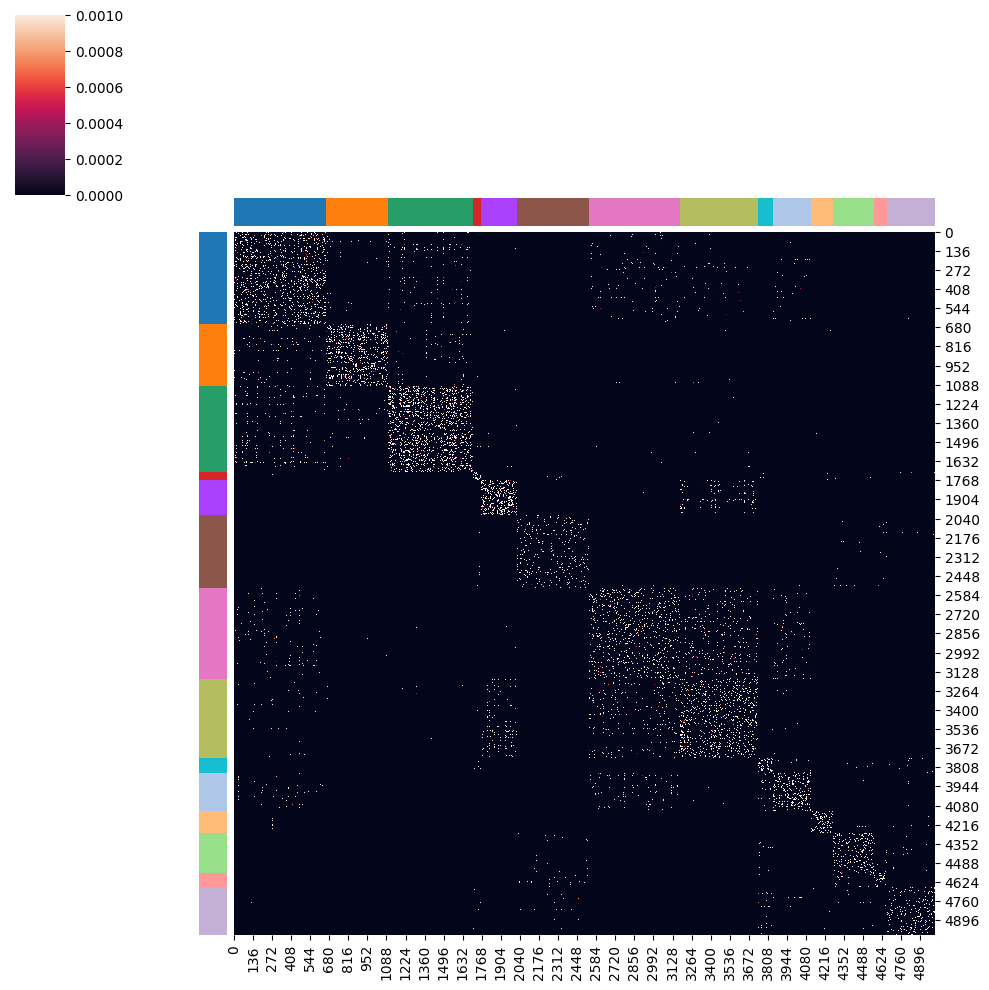

In [13]:
import seaborn as sb
c = np.array([adata.uns["clusters_colors"][i] for i in  adata.obs.clusters.cat.codes])
sb.clustermap(W[idx, :][:, idx], row_cluster = False, col_cluster = False, vmax = 0.001, row_colors = c[idx], col_colors = c[idx], rasterized=True)
plt.savefig("../figures/dentate_heatmap_colors.pdf")

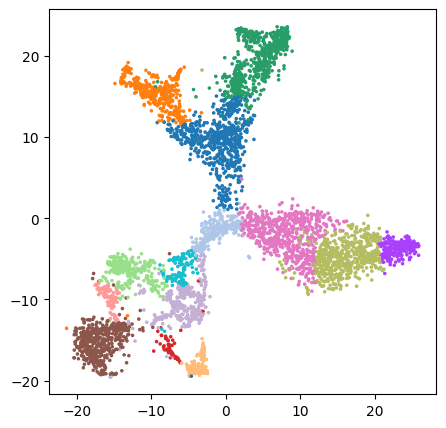

In [68]:
plt.figure(figsize = (5, 5))
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = c, s = 2.5, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True)
plt.savefig("../figures/dentate_clusters_scatter.pdf", dpi = 300)

/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


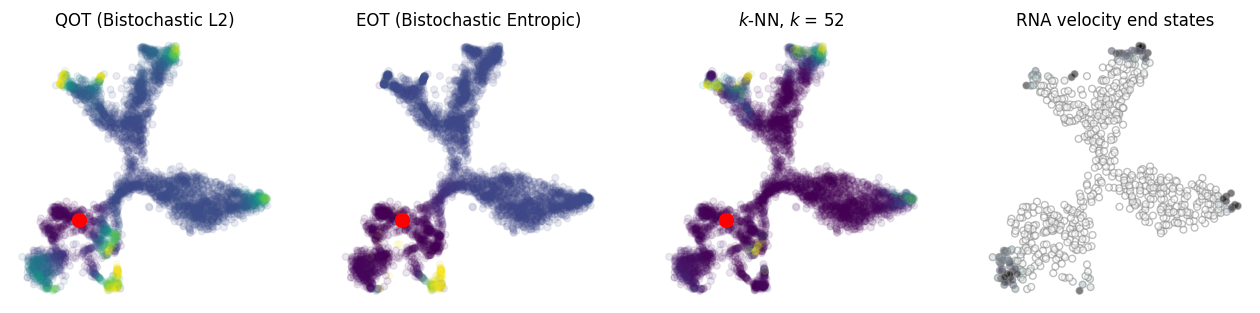

In [69]:
plt.figure(figsize = (16, 3.5))
plt.subplot(1, 4, 1)
z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_quad, "sqeuclidean"))[adata.uns['iroot'], :]
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = z, s = 24, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True, alpha = 0.1)
plt.scatter(adata.obsm["X_tsne"][[adata.uns['iroot'], ], 0], adata.obsm["X_tsne"][[adata.uns['iroot'], ], 1], c = 'r', s = 100)
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.axis("off")
plt.title("QOT (Bistochastic L2)")

plt.subplot(1, 4, 2)
z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_ent, "sqeuclidean"))[adata.uns['iroot'], :]
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = z, s = 24, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True, alpha = 0.1)
plt.scatter(adata.obsm["X_tsne"][[adata.uns['iroot'], ], 0], adata.obsm["X_tsne"][[adata.uns['iroot'], ], 1], c = 'r', s = 100)
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.axis("off")
plt.title("EOT (Bistochastic Entropic)")

plt.subplot(1, 4, 3)
z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_knn, "sqeuclidean"))[adata.uns['iroot'], :]
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = z, s = 24, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True, alpha = 0.1)
plt.scatter(adata.obsm["X_tsne"][[adata.uns['iroot'], ], 0], adata.obsm["X_tsne"][[adata.uns['iroot'], ], 1], c = 'r', s = 100)
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.axis("off")
plt.title("$k$-NN, $k$ = 52")

plt.subplot(1, 4, 4)
idx = np.where(~adata.obs.start_prob.isna())[0]
z = adata[idx, :].obs.end_prob # - adata[idx, :].obs.start_prob 
plt.scatter(adata.obsm["X_tsne"][idx, 0], adata.obsm["X_tsne"][idx, 1], c = z, s = 24, cmap = "bone_r", vmax = np.quantile(z, 0.975), vmin = 0, edgecolor = 'grey', alpha = 0.5)
plt.axis("off")
plt.title("RNA velocity end states")

plt.savefig("../figures/dentategyrus_spectral_embedding_distance.pdf", dpi = 300)

In [70]:
lineage_sets = {"CA" : ["CA", "CA2-3-4"], 
                "ImmGranule" : ["ImmGranule1", "ImmGranule2", "Granule"],
                "ImmAstro" : ["ImmAstro"]}

/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/gpfs/projects/punim0638/stephenz/envs/qrot_py/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


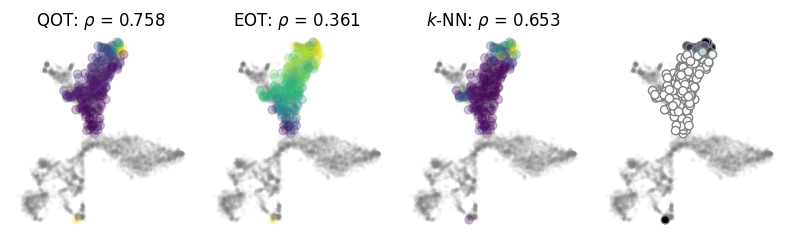

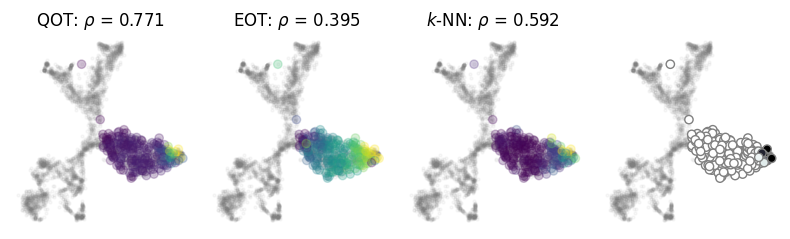

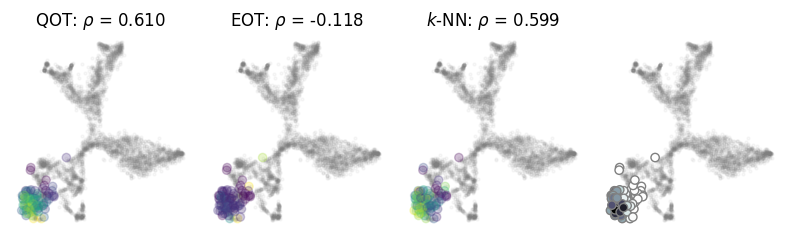

In [71]:
for (k, v) in lineage_sets.items():
    idx = np.where((~adata.obs.end_prob.isna()) & adata.obs.clusters.isin(v))[0]
    adata_subset = adata[idx, :]
    plt.figure(figsize = (8, 2.5))
    plt.subplot(1,4,4)
    z = adata_subset.obs.end_prob 
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], color = 'grey', rasterized = True, alpha = 0.05, s = 5)
    plt.scatter(adata_subset.obsm["X_tsne"][:, 0], adata_subset.obsm["X_tsne"][:, 1], c = z, vmax = np.quantile(z, 0.975), vmin = 0, rasterized = True, cmap = "bone_r", edgecolor = 'grey')
    plt.axis("off")
    plt.subplot(1,4,1)
    _z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_quad, "sqeuclidean"))[adata.uns['iroot'], idx]
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], color = 'grey', rasterized = True, alpha = 0.05, s = 5)
    plt.scatter(adata_subset.obsm["X_tsne"][:, 0], adata_subset.obsm["X_tsne"][:, 1], c = _z, vmax = np.quantile(_z, 0.975), vmin = np.quantile(_z, 0.025), rasterized = True, alpha = 0.25)
    plt.axis("off")
    plt.title(f"QOT: $\\rho$ = {sp.stats.pearsonr(z, _z).statistic:.3f}")
    plt.subplot(1,4,2)
    _z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_ent, "sqeuclidean"))[adata.uns['iroot'], idx]
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], color = 'grey', rasterized = True, alpha = 0.05, s = 5)
    plt.scatter(adata_subset.obsm["X_tsne"][:, 0], adata_subset.obsm["X_tsne"][:, 1], c = _z, vmax = np.quantile(_z, 0.975), vmin = np.quantile(_z, 0.025), rasterized = True, alpha = 0.25)
    plt.axis("off")
    plt.title(f"EOT: $\\rho$ = {sp.stats.pearsonr(z, _z).statistic:.3f}")
    plt.subplot(1,4,3)
    _z = sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_emb_knn, "sqeuclidean"))[adata.uns['iroot'], idx]
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], color = 'grey', rasterized = True, alpha = 0.05, s = 5)
    plt.scatter(adata_subset.obsm["X_tsne"][:, 0], adata_subset.obsm["X_tsne"][:, 1], c = _z, vmax = np.quantile(_z, 0.975), vmin = np.quantile(_z, 0.025), rasterized = True, alpha = 0.25)
    plt.axis("off")
    plt.title(f"$k$-NN: $\\rho$ = {sp.stats.pearsonr(z, _z).statistic:.3f}")
    # plt.suptitle(k)
    plt.tight_layout()
    plt.savefig(f"../figures/dentategyrus_spectral_embedding_distance_cluster_{k}.pdf", dpi = 300)

In [39]:
U_quad, U_ent = np.load("U_quad.npy"), np.load("U_ent.npy")

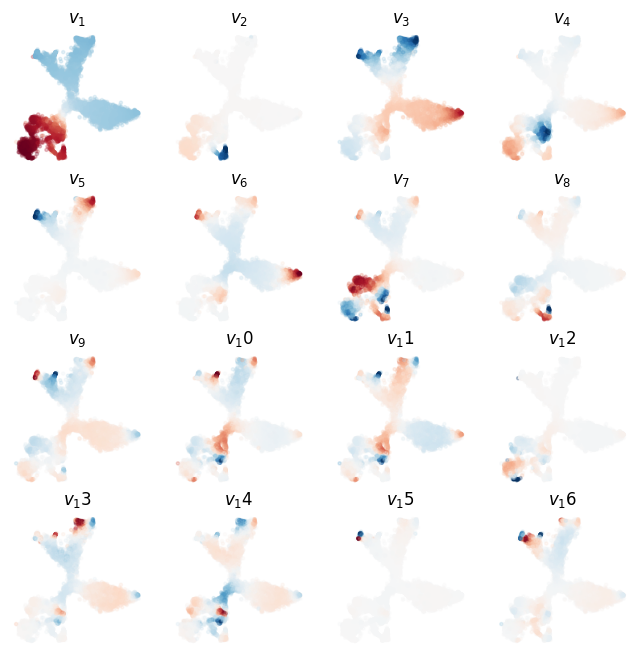

In [96]:
plt.figure(figsize = (8, 8))
for i in range(16):
    plt.subplot(4,4,i+1)
    z = U_quad[:, i+1]
    zmax = np.quantile(np.abs(z), 0.995)
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = z, rasterized = True, alpha = 0.25, s = 5, cmap = "RdBu_r", vmin = -zmax, vmax = zmax)
    plt.title(f"$v_{(i+1)}$")
    plt.axis("off")

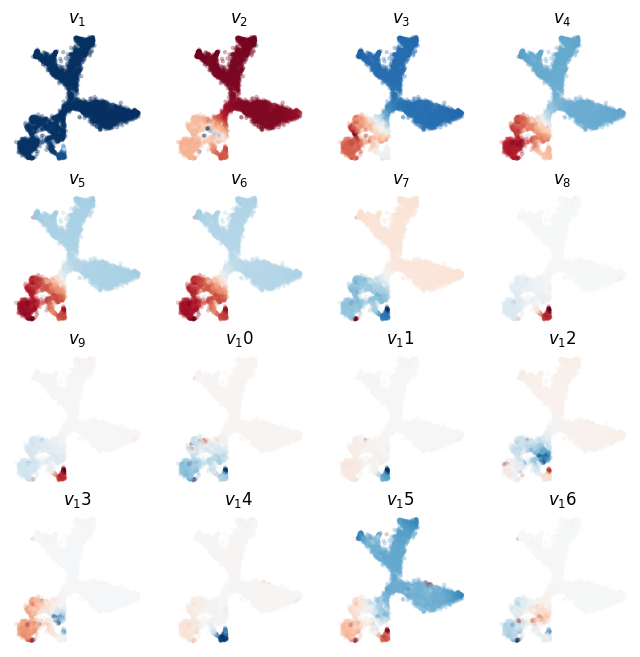

In [93]:
plt.figure(figsize = (8, 8))
for i in range(16):
    plt.subplot(4,4,i+1)
    z = U_ent[:, i+1]
    zmax = np.quantile(np.abs(z), 0.995)
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = z, rasterized = True, alpha = 0.25, s = 5, cmap = "RdBu_r", vmin = -zmax, vmax = zmax)
    plt.title(f"$v_{(i+1)}$")
    plt.axis("off")

In [149]:
sp.linalg.eigh(A.todense())

(array([-143.48057339,  -42.55786224,  -27.97495702, ...,   48.77651745,
          78.11933863,  199.97085068]),
 array([[-0.01251239, -0.01138886,  0.00248123, ..., -0.00804229,
          0.007172  , -0.01040601],
        [-0.00330097,  0.00134528, -0.02525026, ...,  0.01070799,
         -0.00118704, -0.01775109],
        [-0.01074558,  0.00534774,  0.01575479, ..., -0.0030455 ,
         -0.0016739 , -0.00925828],
        ...,
        [ 0.01151399, -0.08803932, -0.05567235, ..., -0.05543424,
         -0.13855667, -0.01850807],
        [-0.00717481,  0.00611775, -0.02408441, ...,  0.0267696 ,
         -0.00073626, -0.00703492],
        [-0.01320429,  0.00091467, -0.00905655, ..., -0.00034764,
          0.00252256, -0.01105691]]))

<AxesSubplot: >

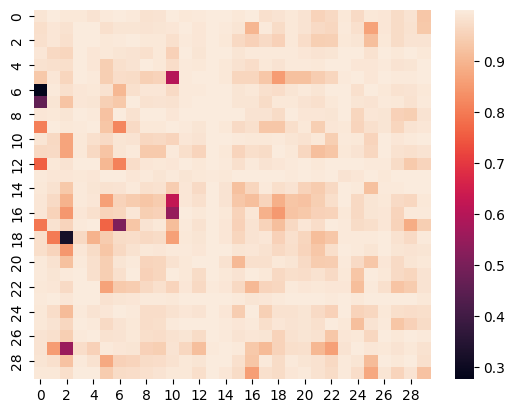

In [145]:
idx = range(2, 32)
C = np.minimum(sp.spatial.distance.cdist(U_ent[:, idx].T, U_quad[:, idx].T, metric = 'cosine'), sp.spatial.distance.cdist(U_ent[:, idx].T, -U_quad[:, idx].T, metric = 'cosine'))
sb.heatmap(C)

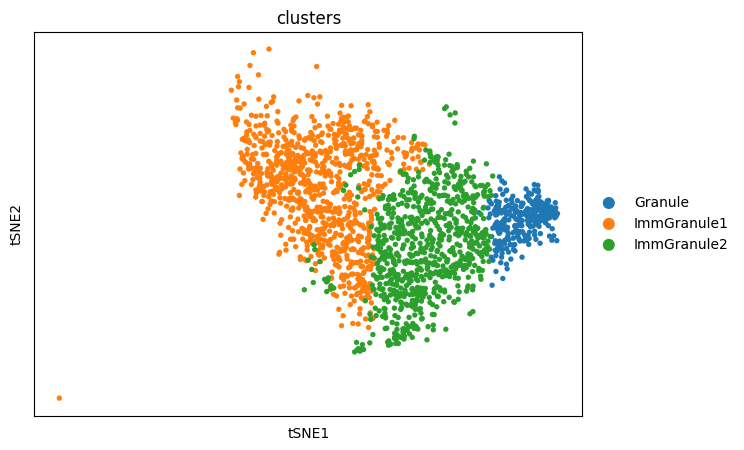

In [66]:
# Heteroskedastic noise
np.random.seed(42)
adata = scvelo.datasets.dentategyrus_lamanno(); adata.obs.celltypes = adata.obs.clusters
adata.obs["start_prob"] = pd.read_csv("../../data/dentate_gyrus/start_probs.csv", index_col = 0).start_prob
adata.obs["end_prob"] = pd.read_csv("../../data/dentate_gyrus/end_probs.csv", index_col = 0).end_prob
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.layers["raw"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset = True)
sc.pp.scale(adata, max_value=10)
adata = adata[adata.obs.clusters.isin(["ImmGranule1", "ImmGranule2", "Granule"]), :]
sc.pp.subsample(adata, n_obs = 2000, random_state = 0)
sc.pl.scatter(adata, basis = "tsne", color = "clusters")

In [366]:
np.median(np.asarray(adata.layers['raw'].sum(-1)).flatten())

288.0

Text(0.5, 0, 'Reads')

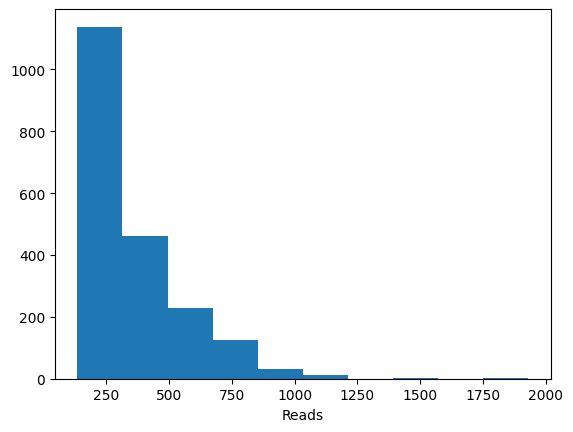

In [67]:
plt.hist(np.asarray(adata.layers['raw'].sum(-1)).flatten())
plt.xlabel("Reads")

In [68]:
np.random.seed(42)
N = adata.shape[0]
perm=np.random.permutation(adata.shape[0])
batches = [adata.obs.index[perm[:N//2]], adata.obs.index[perm[N//2:]]]
from tqdm import tqdm
def get_mult_sample(x, n):
    return np.random.multinomial(n, x/x.sum())
X_batch0=sp.sparse.csc_matrix(np.vstack([get_mult_sample(np.asarray(x.todense(), dtype = np.float64).flatten(), 250) for x in tqdm(adata[batches[0]].layers['raw'], position=0, leave=True)]))
X_batch1=sp.sparse.csc_matrix(np.vstack([get_mult_sample(np.asarray(x.todense(), dtype = np.float64).flatten(), 100) for x in tqdm(adata[batches[1]].layers['raw'], position=0, leave=True)]))

1000it [00:00, 12008.98it/s]
1000it [00:00, 12369.80it/s]


In [69]:
adata_batch = ad.AnnData(X=sp.sparse.vstack([X_batch0, X_batch1]))
adata_batch = ad.AnnData(X=sp.sparse.vstack([X_batch0, X_batch1]))
adata_batch.obs=pd.concat([adata[batches[0]].obs, adata[batches[1]].obs])
sc.pp.normalize_total(adata_batch, target_sum=1e4)
sc.pp.log1p(adata_batch)
sc.pp.scale(adata_batch, max_value=10)
sc.pp.pca(adata_batch)
adata_batch.obs["batch"]=0
adata_batch.obs.loc[batches[0], 'batch']=0
adata_batch.obs.loc[batches[1], 'batch']=1
adata_batch.uns['clusters_colors']=adata.uns['clusters_colors']

In [70]:
X = adata_batch.X; np.save("X_batch.npy", X)
X_pca = adata_batch.obsm["X_pca"]
np.save("X_batch_pca.npy", X_pca)

In [289]:
W_quad = np.load("W_quad_batch.npy"); U_quad = np.load("U_quad_batch.npy"); u_quad = np.load("u_quad_batch.npy")
W_ent = np.load("W_ent_batch.npy"); U_ent = np.load("U_ent_batch.npy"); u_ent = np.log(np.load("u_ent_batch.npy"))
W_gauss = np.load("W_gauss_batch.npy")
W_epanech = np.load("W_epanech_batch.npy")

In [301]:
# do a stable sort
idx_batch = np.argsort(adata_batch.obs.batch, kind = 'stable')
idx_cluster = np.argsort(adata_batch.obs.clusters[idx_batch].cat.codes, kind = 'stable')

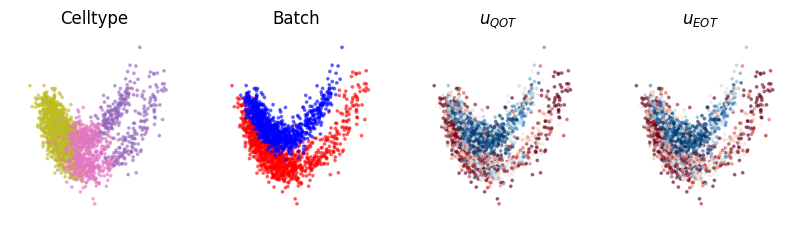

In [278]:
import matplotlib.patches as mpatches
plt.figure(figsize = (10, 2.5))
plt.subplot(1, 4, 1)
plt.scatter(adata_batch.obsm["X_pca"][:, 0], adata_batch.obsm["X_pca"][:, 1], s = 3, rasterized = True, c = [adata_batch.uns["clusters_colors"][i] for i in adata_batch.obs.clusters.cat.codes], alpha = 0.5)
plt.title("Celltype")
plt.xlim(-12, 17.5); plt.ylim(-10, 12); plt.axis("off")
plt.subplot(1, 4, 2)
plt.scatter(adata_batch.obsm["X_pca"][:, 0], adata_batch.obsm["X_pca"][:, 1], c = [batch_colors[i] for i in adata_batch.obs.batch], s = 3, rasterized = True, alpha = 0.5)
plt.xlim(-12, 17.5); plt.ylim(-10, 12); plt.axis("off")
plt.title("Batch")
plt.subplot(1, 4, 3)
plt.scatter(adata_batch.obsm["X_pca"][:, 0], adata_batch.obsm["X_pca"][:, 1], c = (u_quad - u_quad.mean())/u_quad.std(), cmap = "RdBu_r", vmin = -1, vmax = 1, alpha = 0.5, s = 3, rasterized = True)
plt.xlim(-12, 17.5); plt.ylim(-10, 12); plt.axis("off")
plt.title("$u_{QOT}$")
plt.subplot(1, 4, 4)
plt.scatter(adata_batch.obsm["X_pca"][:, 0], adata_batch.obsm["X_pca"][:, 1], c = (u_ent - u_ent.mean())/u_ent.std(), cmap = "RdBu_r", vmin = -1, vmax = 1, alpha = 0.5, s = 3, rasterized = True)
plt.xlim(-12, 17.5); plt.ylim(-10, 12); plt.axis("off")
plt.title("$u_{EOT}$")
plt.savefig("../../figures/dentategyrus_pca_batch.pdf", dpi = 300)

In [73]:
knn_op = sk.neighbors.NearestNeighbors(n_neighbors = 50, algorithm = "auto", n_jobs = 16)
knn_op.fit(X)
A = np.asarray(knn_op.kneighbors_graph(X).todense())
A = (A + A.T)/2
A = A * (A.sum(-1)[:, None] * A.sum(-1)[None, :])**(-0.5)
_, U_knn = np.linalg.eigh(np.eye(A.shape[0]) - A)

In [414]:
# POT test
# C = ot.utils.euclidean_distances(X, X, squared = True) 
# C /= C.mean()
# np.fill_diagonal(C, np.inf)
# # T = ot.sinkhorn(np.ones(X.shape[0]), np.ones(X.shape[0]), C, 0.05)
# T = ot.smooth.smooth_ot_dual(np.ones(X.shape[0]), np.ones(X.shape[0]), C, 1.5)
# plt.imshow(T[idx, :][:, idx], cmap = "Blues", vmax = 1e-3); plt.axis("off")
# y = sk.manifold.SpectralEmbedding(affinity = 'precomputed').fit_transform(T)
# plt.scatter(y[:, 0], y[:, 1])

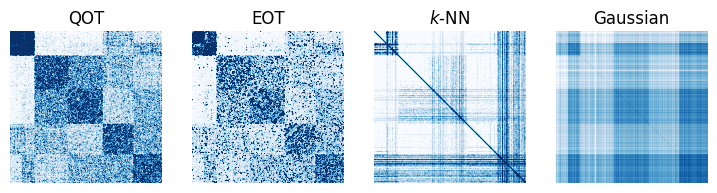

In [355]:
import seaborn as sb
# idx = np.array(np.argsort(adata_batch.obs.clusters))
idx = idx_batch[idx_cluster]
plt.figure(figsize = (9, 3))
plt.subplot(1, 4, 1)
plt.imshow(W_quad[idx, :][:, idx], cmap = "Blues", vmax = 1e-3); plt.axis("off")
plt.title("QOT")
plt.subplot(1, 4, 2)
plt.imshow(W_ent[idx, :][:, idx], cmap = "Blues", vmax = 1e-3); plt.axis("off")
plt.title("EOT")
plt.subplot(1, 4, 3)
plt.imshow(A[idx, :][:, idx], cmap = "Blues", vmax = 1e-3); plt.axis("off")
plt.title("$k$-NN")
plt.subplot(1, 4, 4)
_W = W_gauss.copy()
np.fill_diagonal(_W, 1)
_W = np.log(_W[idx, :][:, idx])
plt.imshow(_W, cmap = "Blues", vmin = -40, vmax = -10); plt.axis("off")
plt.title("Gaussian")
plt.savefig("../../figures/dentategyrus_affinity_batch.pdf", dpi = 300)

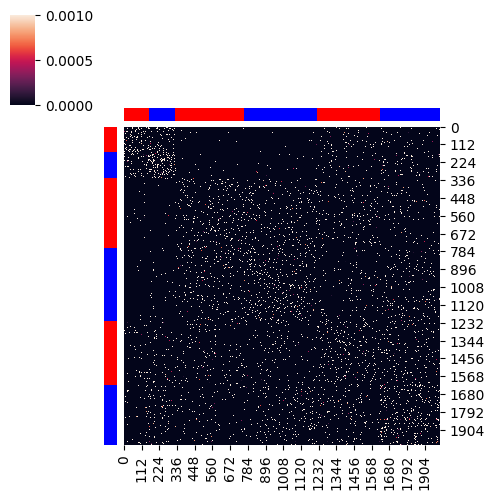

In [357]:
c = np.array([batch_colors[i] for i in  adata_batch.obs.batch])
sb.clustermap(W_quad[idx, :][:, idx], row_cluster = False, col_cluster = False, vmax = 0.001, row_colors = c[idx], col_colors = c[idx], rasterized=True, figsize = (5, 5))
plt.savefig("../../figures/dentategyrus_W_quad_batch.pdf")

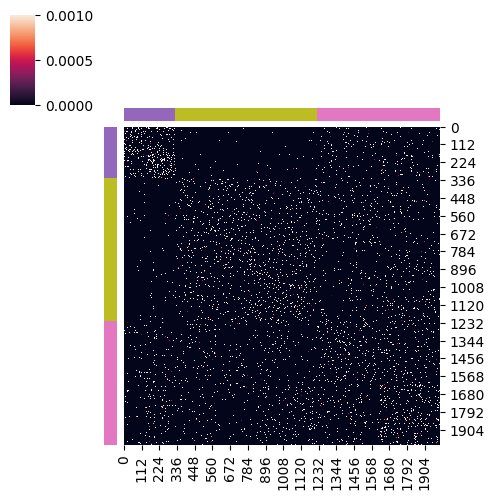

In [359]:
c = np.array([adata_batch.uns["clusters_colors"][i] for i in adata_batch.obs.clusters.cat.codes])
idx = idx_batch[idx_cluster]
sb.clustermap(W_quad[idx, :][:, idx], row_cluster = False, col_cluster = False, vmax = 0.001, row_colors = c[idx], col_colors = c[idx], rasterized=True, figsize = (5, 5))
plt.savefig("../../figures/dentategyrus_W_quad_celltype.pdf")

In [84]:
from openTSNE import TSNEEmbedding
from openTSNE import affinity, initialization

sc.tl.tsne(adata_batch)
for (W, what) in [(W_ent, "ent"), (W_quad, "quad"), (A, "knn")]:
    aff = affinity.PrecomputedAffinities(W)
    emb = TSNEEmbedding(
        adata_batch.obsm["X_pca"][:, range(2)],
        aff,
        negative_gradient_method="fft",
        n_jobs=16,
        verbose=True,
        random_state=42,
    )
    emb = emb.optimize(n_iter=250, exaggeration=12)
    emb = emb.optimize(n_iter=500)
    adata_batch.obsm[f"X_tsne_{what}"] = np.asarray(emb)

===> Running optimization with exaggeration=12.00, lr=166.67 for 250 iterations...
Iteration   50, KL divergence 4.1803, 50 iterations in 0.6931 sec
Iteration  100, KL divergence 4.1891, 50 iterations in 0.6683 sec
Iteration  150, KL divergence 4.1938, 50 iterations in 0.6942 sec
Iteration  200, KL divergence 4.1960, 50 iterations in 0.6574 sec
Iteration  250, KL divergence 4.1928, 50 iterations in 0.6680 sec
   --> Time elapsed: 3.38 seconds
===> Running optimization with exaggeration=1.00, lr=2000.00 for 500 iterations...
Iteration   50, KL divergence 2.8045, 50 iterations in 0.7083 sec
Iteration  100, KL divergence 2.6354, 50 iterations in 0.7717 sec
Iteration  150, KL divergence 2.5497, 50 iterations in 1.3079 sec
Iteration  200, KL divergence 2.4988, 50 iterations in 1.7983 sec
Iteration  250, KL divergence 2.4646, 50 iterations in 2.3285 sec
Iteration  300, KL divergence 2.4408, 50 iterations in 2.8779 sec
Iteration  350, KL divergence 2.4213, 50 iterations in 3.3695 sec
Iteratio

In [204]:
adata.uns["clusters_colors"]

['#1f77b4', '#ff7f0e', '#2ca02c']

In [234]:
from matplotlib import colors
adata_batch.uns["clusters_colors"] = ["#9467bd", "#bcbd22", "#e377c2",]

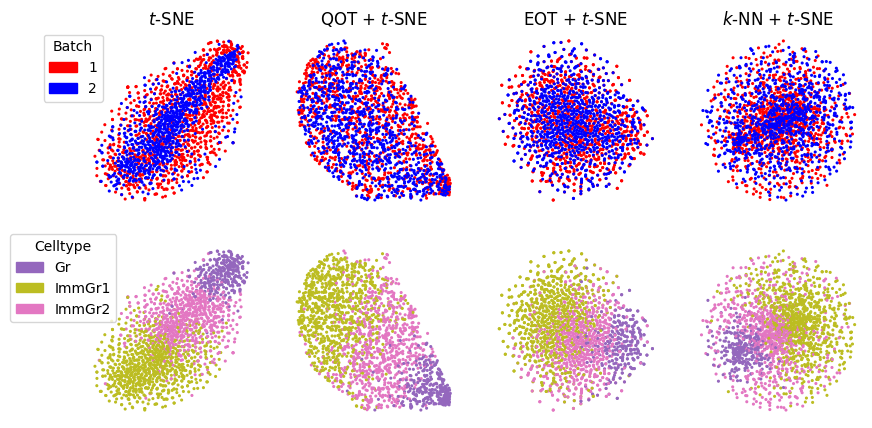

In [235]:
plt.figure(figsize = (10, 5))
plt.subplot(2, 4, 2)
plt.scatter(adata_batch.obsm["X_tsne_quad"][:, 0], adata_batch.obsm["X_tsne_quad"][:, 1], c = [batch_colors[i] for i in adata_batch.obs.batch], alpha = 1, s = 1.5, rasterized = True); plt.axis('off')
plt.title("QOT + $t$-SNE")
plt.subplot(2, 4, 3)
plt.scatter(adata_batch.obsm["X_tsne_ent"][:, 0], adata_batch.obsm["X_tsne_ent"][:, 1], c = [batch_colors[i] for i in adata_batch.obs.batch], alpha = 1, s = 1.5, rasterized = True); plt.axis('off')
plt.title("EOT + $t$-SNE")
plt.subplot(2, 4, 1)
plt.scatter(adata_batch.obsm["X_tsne"][:, 0], adata_batch.obsm["X_tsne"][:, 1], c = [batch_colors[i] for i in adata_batch.obs.batch], alpha = 1, s = 1.5, rasterized = True); plt.axis('off')
import matplotlib.patches as mpatches
plt.legend(handles=[mpatches.Patch(color='red', label='1'), mpatches.Patch(color='blue', label='2')], title = "Batch", loc='center left', bbox_to_anchor=(-0.3, 0.8))

plt.title("$t$-SNE")
plt.subplot(2, 4, 4)
plt.scatter(adata_batch.obsm["X_tsne_knn"][:, 0], adata_batch.obsm["X_tsne_knn"][:, 1], c = [batch_colors[i] for i in adata_batch.obs.batch], alpha = 1, s = 1.5, rasterized = True); plt.axis('off')
plt.title("$k$-NN + $t$-SNE")
plt.subplot(2, 4, 6)
plt.scatter(adata_batch.obsm["X_tsne_quad"][:, 0], adata_batch.obsm["X_tsne_quad"][:, 1], c = [adata_batch.uns["clusters_colors"][i] for i in adata_batch.obs.clusters.cat.codes], alpha = 1, s = 1.5, rasterized = True); plt.axis('off')
plt.subplot(2, 4, 7)
plt.scatter(adata_batch.obsm["X_tsne_ent"][:, 0], adata_batch.obsm["X_tsne_ent"][:, 1], c = [adata_batch.uns["clusters_colors"][i] for i in adata_batch.obs.clusters.cat.codes], alpha = 1, s = 1.5, rasterized = True); plt.axis('off')
plt.subplot(2, 4, 5)
plt.scatter(adata_batch.obsm["X_tsne"][:, 0], adata_batch.obsm["X_tsne"][:, 1], c = [adata_batch.uns["clusters_colors"][i] for i in adata_batch.obs.clusters.cat.codes], alpha = 1, s = 1.5, rasterized = True); plt.axis('off')
plt.legend(handles=[mpatches.Patch(color=adata_batch.uns["clusters_colors"][i], label={0 : "Gr", 1 : "ImmGr1", 2: "ImmGr2"}[i]) for i in range(3)], title = "Celltype", loc='center left', bbox_to_anchor=(-0.5, 0.8))
plt.subplot(2, 4, 8)
plt.scatter(adata_batch.obsm["X_tsne_knn"][:, 0], adata_batch.obsm["X_tsne_knn"][:, 1], c = [adata_batch.uns["clusters_colors"][i] for i in adata_batch.obs.clusters.cat.codes], alpha = 1, s = 1.5, rasterized = True); plt.axis('off')
# plt.tight_layout()
plt.savefig("../../figures/dentategyrus_tSNE_batch.pdf", dpi = 300)

In [368]:
X.shape

(2000, 2239)